In [1]:
import spacy

from heimdallr.adapters.db import ClientFactory
from heimdallr.adapters.motor_repositories import MotorAssignmentRepository
from heimdallr.dependencies import NLP_SPANISH

nlp = spacy.load(NLP_SPANISH)
repository = MotorAssignmentRepository(client=ClientFactory(url="mongodb://localhost:27017")(), db_name="heimdallr-dev")

In [2]:
assignments = await repository.find_all()

print(f"Found {len(assignments)}")

Found 98


In [3]:
train = [{'text': ' '.join(assignment.content), 'label': str(assignment.topic)} for assignment in assignments]

In [4]:
import pandas as pd

df = pd.DataFrame(train)

print(df.head())

                                                text               label
0  MARKETING EN INTERNET Y NUEVA ECONOMÍA 2° CUAT...    Emerging Systems
1  MARKETING EN INTERNET Y NUEVA ECONOMÍA 2° CUAT...    Emerging Systems
2  MARKETING EN INTERNET Y NUEVA ECONOMÍA 2° CUAT...  Experience Economy
3  Marketing en Internet y Nueva Economía Trabajo...     Digital Economy
4  Marketing en Internet y Nueva Economía Trabajo...     Digital Economy


In [5]:
from sklearn.model_selection import train_test_split

train, test = train_test_split(df, test_size=0.33, random_state=42)

print('Conference of this paper:', train['label'].iloc[0])
print('Training Data Shape:', train.shape)
print('Testing Data Shape:', test.shape)

Conference of this paper: Digital Economy
Training Data Shape: (65, 2)
Testing Data Shape: (33, 2)


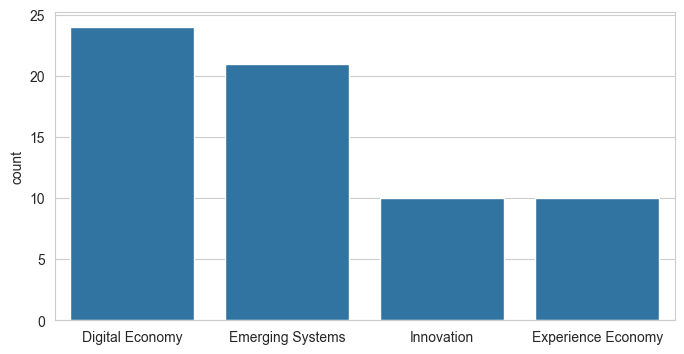

In [6]:
from matplotlib import pyplot as plt
import seaborn as sns

fig = plt.figure(figsize=(8, 4))
sns.barplot(x=train['label'].unique(), y=train['label'].value_counts())
plt.show()

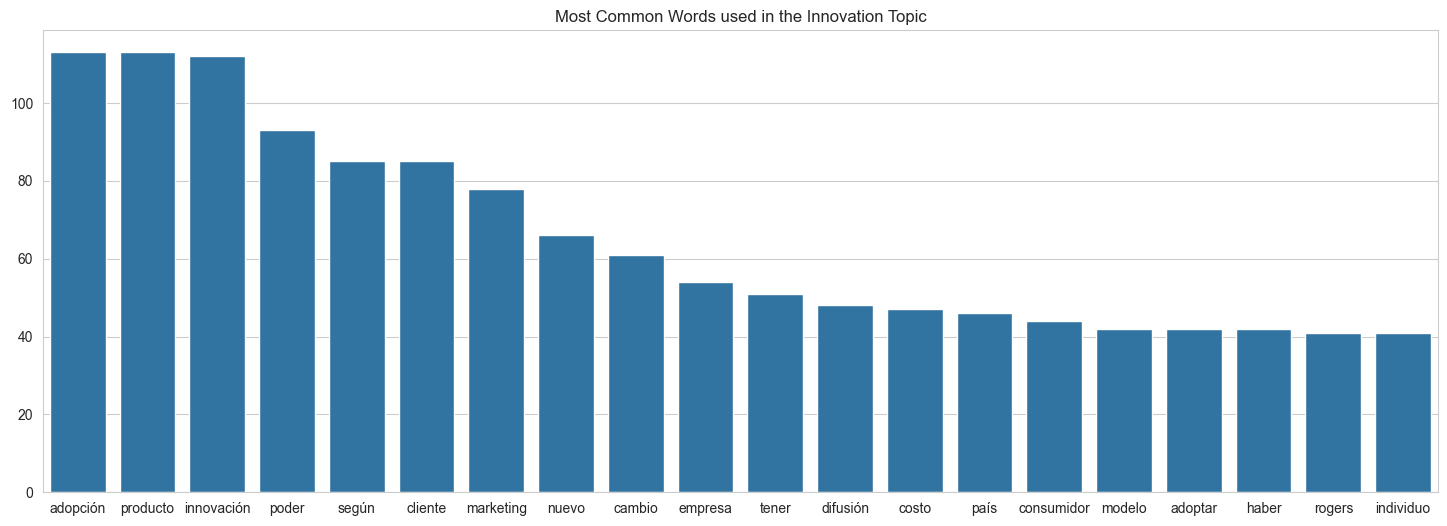

In [7]:

from collections import Counter
from nltk.corpus import stopwords
import string

punctuations = string.punctuation
stopwords = stopwords.words('spanish') + ["ser", "él", "el", "la", "los", "las", "un", "una", "unos", "unas", "al",
                                          "del", "este", "esta", "estos", "estas", "entre", "sobre", "todo", "toda",
                                          "todas", "todos", "otro", "otra", "otros"]

SYMBOLS = " ".join(string.punctuation).split(" ") + ["-", "...", "”", "”", "'", "“", "¿"]


def cleanup_text(docs, logging=False):
    texts = []
    counter = 1
    for doc in docs:
        if counter % 1000 == 0 and logging:
            print("Processed %d out of %d documents." % (counter, len(docs)))
        counter += 1
        doc = nlp(doc, disable=['parser', 'ner'])
        tokens = [tok.lemma_.lower().strip() for tok in doc if tok.lemma_ != '-PRON-']
        tokens = [tok for tok in tokens if tok not in stopwords and tok not in SYMBOLS and not tok.isdigit()]
        tokens = ' '.join(tokens)
        texts.append(tokens)
    return pd.Series(texts)


DE_text = [text for text in train[train['label'] == 'Digital Economy']['text']]
DE_clean = cleanup_text(DE_text)
DE_clean = ' '.join(DE_clean).split()
DE_counts = Counter(DE_clean)

ES_text = [text for text in train[train['label'] == 'Innovation']['text']]
ES_clean = cleanup_text(ES_text)
ES_clean = ' '.join(ES_clean).split()
ES_counts = Counter(ES_clean)

DE_common_words = [word[0] for word in ES_counts.most_common(20)]
DE_common_counts = [word[1] for word in ES_counts.most_common(20)]

fig = plt.figure(figsize=(18, 6))
sns.barplot(x=DE_common_words, y=DE_common_counts)
plt.title('Most Common Words used in the Innovation Topic')
plt.show()

In [8]:
from sklearn.metrics import accuracy_score
from sklearn.pipeline import Pipeline
from sklearn.svm import LinearSVC
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.base import TransformerMixin
from spacy.lang.es import Spanish

parser = Spanish()


class CleanTextTransformer(TransformerMixin):

    def transform(self, x, **transform_params):
        return [cleanText(text) for text in x]

    def fit(self, X, y=None, **fit_params):
        return self


def cleanText(text):
    text = text.strip().replace("\n", " ").replace("\r", " ")
    text = text.lower()
    return text


def tokenizeText(sample):
    tokens = nlp(sample)
    lemmas = []
    for tok in tokens:
        lemmas.append(tok.lemma_.lower().strip() if tok.lemma_ != "-PRON-" else tok.lower_)
    tokens = lemmas
    tokens = [tok for tok in tokens if tok not in stopwords]
    tokens = [tok for tok in tokens if tok not in SYMBOLS]
    return tokens


def printNMostInformative(vectorizer: CountVectorizer, clf, N):
    feature_names = vectorizer.get_feature_names_out()
    coefs_with_fns = sorted(zip(clf.coef_[0], feature_names))
    topClass1 = coefs_with_fns[:N]
    topClass2 = coefs_with_fns[:-(N + 1):-1]
    print("Class 1 best: ")
    for feat in topClass1:
        print(feat)
    print("Class 2 best: ")
    for feat in topClass2:
        print(feat)


vectorizer = CountVectorizer(tokenizer=tokenizeText, ngram_range=(1, 1))
clf = LinearSVC()

pipe = Pipeline([('cleanText', CleanTextTransformer()), ('vectorizer', vectorizer), ('clf', clf)])

# data
train1 = train['text'].tolist()
labelsTrain1 = train['label'].tolist()

test1 = test['text'].tolist()
labelsTest1 = test['label'].tolist()
# train
pipe.fit(train1, labelsTrain1)
# test
preds = pipe.predict(test1)
print("accuracy:", accuracy_score(labelsTest1, preds))
print("Top 10 features used to predict: ")

printNMostInformative(vectorizer, clf, 10)
# pipe = Pipeline([('cleanText', CleanTextTransformer()), ('vectorizer', vectorizer)])
# transform = pipe.fit_transform(train1, labelsTrain1)
# vocab = vectorizer.get_feature_names_out()
# for i in range(len(train1)):
#     s = ""
#     indexIntoVocab = transform.indices[transform.indptr[i]:transform.indptr[i + 1]]
#     numOccurences = transform.data[transform.indptr[i]:transform.indptr[i + 1]]
#     for idx, num in zip(indexIntoVocab, numOccurences):
#         s += str((vocab[idx], num))

C:\Users\Tomas\AppData\Local\pypoetry\Cache\virtualenvs\heimdallr-BxNfmjxl-py3.10\lib\site-packages\sklearn\feature_extraction\text.py:525: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
C:\Users\Tomas\AppData\Local\pypoetry\Cache\virtualenvs\heimdallr-BxNfmjxl-py3.10\lib\site-packages\sklearn\svm\_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(


accuracy: 0.9696969696969697
Top 10 features used to predict: 
Class 1 best: 
(-0.029103004130670084, 'ejemplo')
(-0.0196886515112113, 'e.')
(-0.01691611186291786, 'poder')
(-0.016446345666225704, 'individuo')
(-0.01563370008673147, 'sistema')
(-0.01447009033960165, 'idea')
(-0.014373763458333952, 'cliente')
(-0.014351815424658713, 'forma')
(-0.013436619776086544, 'preguntar')
(-0.013324534635813495, 'desarrollar')
Class 2 best: 
(0.04238776378333839, 'economía')
(0.029182852464727033, 'digital')
(0.02722438435484924, 'fuente')
(0.020542621326544958, 'energía')
(0.01983169112684754, 'internet')
(0.017813698257874492, 'cola')
(0.015380021311022321, 'largo')
(0.015285754241537362, 'red')
(0.012455512883773086, 'bien')
(0.012392998237405455, 'cualquiera')


In [9]:
from sklearn import metrics

print(metrics.classification_report(labelsTest1, preds, target_names=df['label'].unique()))

                    precision    recall  f1-score   support

  Emerging Systems       1.00      0.92      0.96        12
Experience Economy       1.00      1.00      1.00         7
   Digital Economy       1.00      1.00      1.00         5
        Innovation       0.90      1.00      0.95         9

          accuracy                           0.97        33
         macro avg       0.97      0.98      0.98        33
      weighted avg       0.97      0.97      0.97        33


In [13]:
from heimdallr.adapters import text_processing
from nltk.corpus import stopwords
import string
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.pipeline import Pipeline
from sklearn.svm import LinearSVC

punctuations = string.punctuation
stopwords = stopwords.words('spanish') + ["ser", "él", "el", "la", "los", "las", "un", "una", "unos", "unas", "al",
                                          "del", "este", "esta", "estos", "estas", "entre", "sobre", "todo", "toda",
                                          "todas", "todos", "otro", "otra", "otros"]

SYMBOLS = " ".join(string.punctuation).split(" ") + ["-", "...", "”", "”", "'", "“", "¿"]
clf = LinearSVC()


def cleanText(text):
    text = text.strip().replace("\n", " ").replace("\r", " ")
    text = text.lower()
    return text


def tokenizeText(sample):
    tokens = nlp(sample)
    lemmas = []
    for tok in tokens:
        lemmas.append(tok.lemma_.lower().strip() if tok.lemma_ != "-PRON-" else tok.lower_)
    tokens = lemmas
    tokens = [tok for tok in tokens if tok not in stopwords]
    tokens = [tok for tok in tokens if tok not in SYMBOLS]
    return tokens


vectorizer = CountVectorizer(tokenizer=tokenizeText, ngram_range=(1, 1))

new_pipe = Pipeline([('cleanText', text_processing.CleanTextTransformer()), ('vectorizer', vectorizer), ('clf', clf)])

# data
train1 = train['text'].tolist()
labelsTrain1 = train['label'].tolist()

test1 = test['text'].tolist()
labelsTest1 = test['label'].tolist()

new_pipe.fit(train1, labelsTrain1)


C:\Users\Tomas\AppData\Local\pypoetry\Cache\virtualenvs\heimdallr-BxNfmjxl-py3.10\lib\site-packages\sklearn\feature_extraction\text.py:525: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
C:\Users\Tomas\AppData\Local\pypoetry\Cache\virtualenvs\heimdallr-BxNfmjxl-py3.10\lib\site-packages\sklearn\svm\_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(


Pipeline(steps=[('cleanText',
                 <heimdallr.adapters.text_processing.CleanTextTransformer object at 0x00000261A8899810>),
                ('vectorizer',
                 CountVectorizer(tokenizer=<function tokenizeText at 0x00000261A58B16C0>)),
                ('clf', LinearSVC())])

In [16]:
emerging_systems = """
MARKETING EN INTERNET Y NUEVA ECONOMIA
TP 6: Sistemas Emergentes
Profesor: Prince, Alejandro
Alumno: Spadafora, Franco Luciano
Legajo: 138332-2

PREGUNTAS TP 
Steven Johnson - Sistemas emergentes

1)	Cuáles son los 4 principios centrales del estudio de los sistemas emergentes?
Interacción de vecinos
Reconocimiento de patrones
Retroalimentación
Control indirecto.

2)	Describa en no más de 10 renglones la particular conducta del Dictiostellum y sus implicancias.
El moho de fango oscila entre ser una única criatura y una colonia. Si las condiciones climáticas cambian y el tiempo se vuelve más húmedo y frío, puede ocurrir que regresen al mismo sitio y comprueben que ha desaparecido por completo.
El moho de fango pasa buena parte de su vida como miles de
Organismos unicelulares distintos; cada uno se mueve independientemente  de sus otros compañeros. Bajo las condiciones adecuadas se producirá la coalescencia de esas miríadas de células en un solo organismo mayor que comienza a reptar pausadamente por el suelo del jardín consumiendo a su paso hojas y cortezas en descomposición. Cuando el entorno es menos favorable, el moho de fango se comporta como un organismo aislado; cuando el tiempo es más frío y el moho dispone de una cantidad de alimento mayor, "él" se transforma en “ellos”.

3)	Qué es la morfogénesis, quién desarrolló esta idea en 1954?
Turing publicó antes de su muerte, en 1954, trataba de la "morfogénesis", la capacidad de todas las formas, de vida de desarrollar cuerpos cada vez más complejos a partir de orígenes increíblemente simples. El trabajo de Turing se centraba en la recurrencia de los patrones numéricos de las flores,6 pero usando
Herramientas matemáticas demostraba cómo un organismo complejo podía desarrollarse sin ninguna dirección o plan maestro.
Es el proceso biológico que lleva a que un organismo desarrolle su forma. Este es uno de los tres aspectos fundamentales del desarrollo biológico junto con el control del crecimiento celular y la diferenciación celular.

Este proceso controla la distribución espacial organizada de las células durante el desarrollo embrionario de un organismo. La morfogénesis también puede tener lugar en un organismo maduro, en un cultivo de células o dentro de un tumor celular. La morfogénesis asimismo, describe el desarrollo de formas de vida unicelular que no atraviesan por una etapa embrionaria en sus ciclos de vida, o describe la evolución de una estructura corporal dentro de un grupo taxonómico.

Las respuestas morfogenéticas podrían ser inducidas en los organismos por las hormonas endógenas, por químicos en el ambiente que van desde sustancias producidas por otros organismos hasta químicos tóxicos y radioisótopos liberados como contaminantes, o por el estrés mecánico inducido por un patrón espacial de células.

4)	Describa los conceptos o conductas “adaptativas” y “complejas”.  Describa sistema ascendente y sistema dinámico.
Son sistemas ascendentes,  Extraen su inteligencia de la base. En un lenguaje más técnico, son sistemas complejos de adaptación que despliegan comportamientos emergentes.13 En estos sistemas, los agentes que residen en una escala comienzan a producir comportamientos que yacen en una escala superior a la suya: las hormigas crean colonias, los habitantes de una ciudad crean barrios, un software de reconocimiento de patrón simple aprende a recomendar libros. La
Evolución de reglas simples a complejas es lo que llamamos "emergencia".

Comportamiento complejo: un sistema con agentes múltiples que interactúan en forma dinámica de múltiples maneras, siguiendo reglas locales e independientes de cualquier instrucción de un nivel superior. Sin embargo, este sistema no sería considerado emergente si las interacciones locales no fueran, en alguna forma, de macroconducta observable.

5)	Describa un sistema emergente o auto organizativo y diferéncielo de un sistema evolutivo o del caos. 
Un sistema es auto-organizable cuando cambia su estructura básica como una función de su experiencia y ambiente, por ejemplo en la red Internet los agentes más simples pueden operar en situaciones imprevistas y adaptarse para cambiar condiciones.
Los sistemas complejos se caracterizan fundamentalmente porque su comportamiento es imprevisible, la interacción entre sus elementos es local y origina un comportamiento emergente que no puede explicarse a partir de dichos elementos tomados aisladamente, es muy difícil predecir su evolución dinámica futura; o sea, es prácticamente imposible vaticinar lo que ocurrirá más allá de un cierto horizonte temporal.
"""


def cleanup_text(docs, logging=False):
    texts = []
    counter = 1
    for doc in docs:
        if counter % 1000 == 0 and logging:
            print("Processed %d out of %d documents." % (counter, len(docs)))
        counter += 1
        doc = nlp(doc, disable=['parser', 'ner'])
        tokens = [tok.lemma_.lower().strip() for tok in doc if tok.lemma_ != '-PRON-']
        tokens = [tok for tok in tokens if tok not in stopwords and tok not in SYMBOLS and not tok.isdigit()]
        tokens = ' '.join(tokens)
        texts.append(tokens)
    return pd.Series(texts)


# preprocess
cleaned_new_text = cleanup_text([emerging_systems])

[predicted_label] = new_pipe.predict(cleaned_new_text)

print(f"Predicted label: {predicted_label}")


Predicted label: Emerging Systems


In [17]:
import joblib

joblib.dump(new_pipe, "models/topic_prediction.joblib")

['topic_prediction.joblib']

In [23]:
loaded_pipe = joblib.load('models/topic_prediction.joblib')

FileNotFoundError: [Errno 2] No such file or directory: 'models/topic_prediction.joblib'

In [21]:
[predicted_label] = loaded_pipe.predict(cleaned_new_text)
print(predicted_label)

Emerging Systems
